In [2]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def get_optical_flow_between_frames(video_path, frame1_idx, frame2_idx):
    """
    Calculate optical flow between two specific frames in a video
    
    Args:
        video_path: Path to the video file
        frame1_idx: Index of the first frame
        frame2_idx: Index of the second frame
        
    Returns:
        tuple: (flow, frame1, frame2) where flow is the optical flow array,
               and frame1/frame2 are the BGR frames
    """
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file {video_path} not found")
        
    cap = cv2.VideoCapture(video_path)
    
    # Get to first frame
    for _ in range(frame1_idx):
        ret = cap.read()[0]
        if not ret:
            raise ValueError("Couldn't reach frame1_idx")
    
    # Read first frame
    ret, frame1 = cap.read()
    if not ret:
        raise ValueError("Couldn't read frame1")
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    
    # Get to second frame
    for _ in range(frame2_idx - frame1_idx - 1):
        ret = cap.read()[0]
        if not ret:
            raise ValueError("Couldn't reach frame2_idx")
    
    # Read second frame
    ret, frame2 = cap.read()
    if not ret:
        raise ValueError("Couldn't read frame2")
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=5,
        poly_n=7,
        poly_sigma=1.5,
        flags=0)
    
    cap.release()
    return flow, frame1, frame2

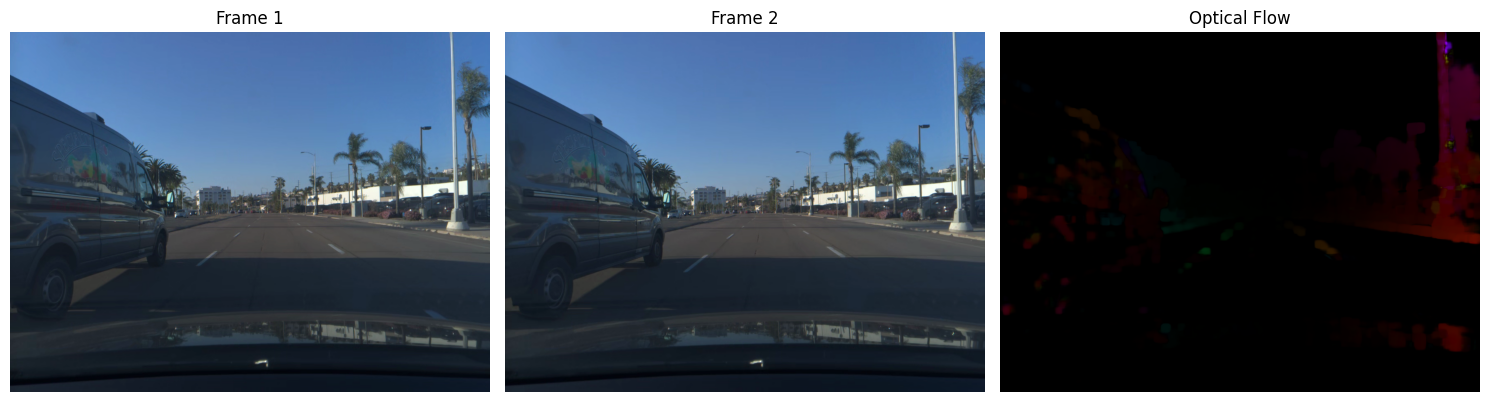

In [3]:
# Example usage
video_path = "labeled/4.hevc"  # adjust this path to your video file
frame1_idx = 187
frame2_idx = 188

# Get the flow and frames
flow, frame1, frame2 = get_optical_flow_between_frames(video_path, frame1_idx, frame2_idx)

# Visualize the frames and flow
plt.figure(figsize=(15, 5))

# Show first frame
plt.subplot(131)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Frame 1')
plt.axis('off')

# Show second frame
plt.subplot(132)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Frame 2')
plt.axis('off')

# Visualize flow using magnitude and direction
plt.subplot(133)
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
hsv[..., 0] = angle * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.imshow(rgb)
plt.title('Optical Flow')
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
#export frame 1
cv2.imwrite("frame1.png", frame1)

True

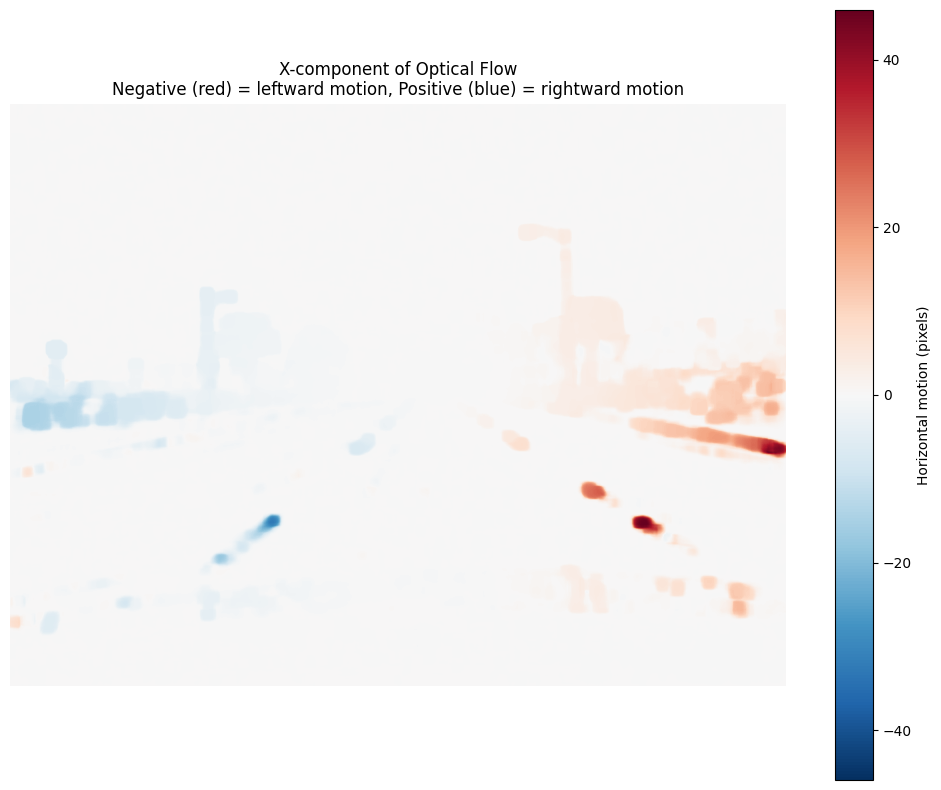

In [27]:
# Plot the first z (x-component) of optical flow
plt.figure(figsize=(10, 8))

# Get the x-component of the flow (horizontal motion)
flow_x = flow[..., 0]

# Create a colormap that shows negative values in red and positive values in blue
# Use a diverging colormap with red-white-blue
cmap = plt.cm.RdBu_r  # _r reverses the colormap so red is negative, blue is positive

# Find the maximum absolute value for symmetric color scaling
max_val = np.max(np.abs(flow_x))

# Plot the x-component of the flow
plt.imshow(flow_x, cmap=cmap, vmin=-max_val, vmax=max_val)
plt.colorbar(label='Horizontal motion (pixels)')
plt.title('X-component of Optical Flow\nNegative (red) = leftward motion, Positive (blue) = rightward motion')
plt.axis('off')
plt.tight_layout()
plt.show()


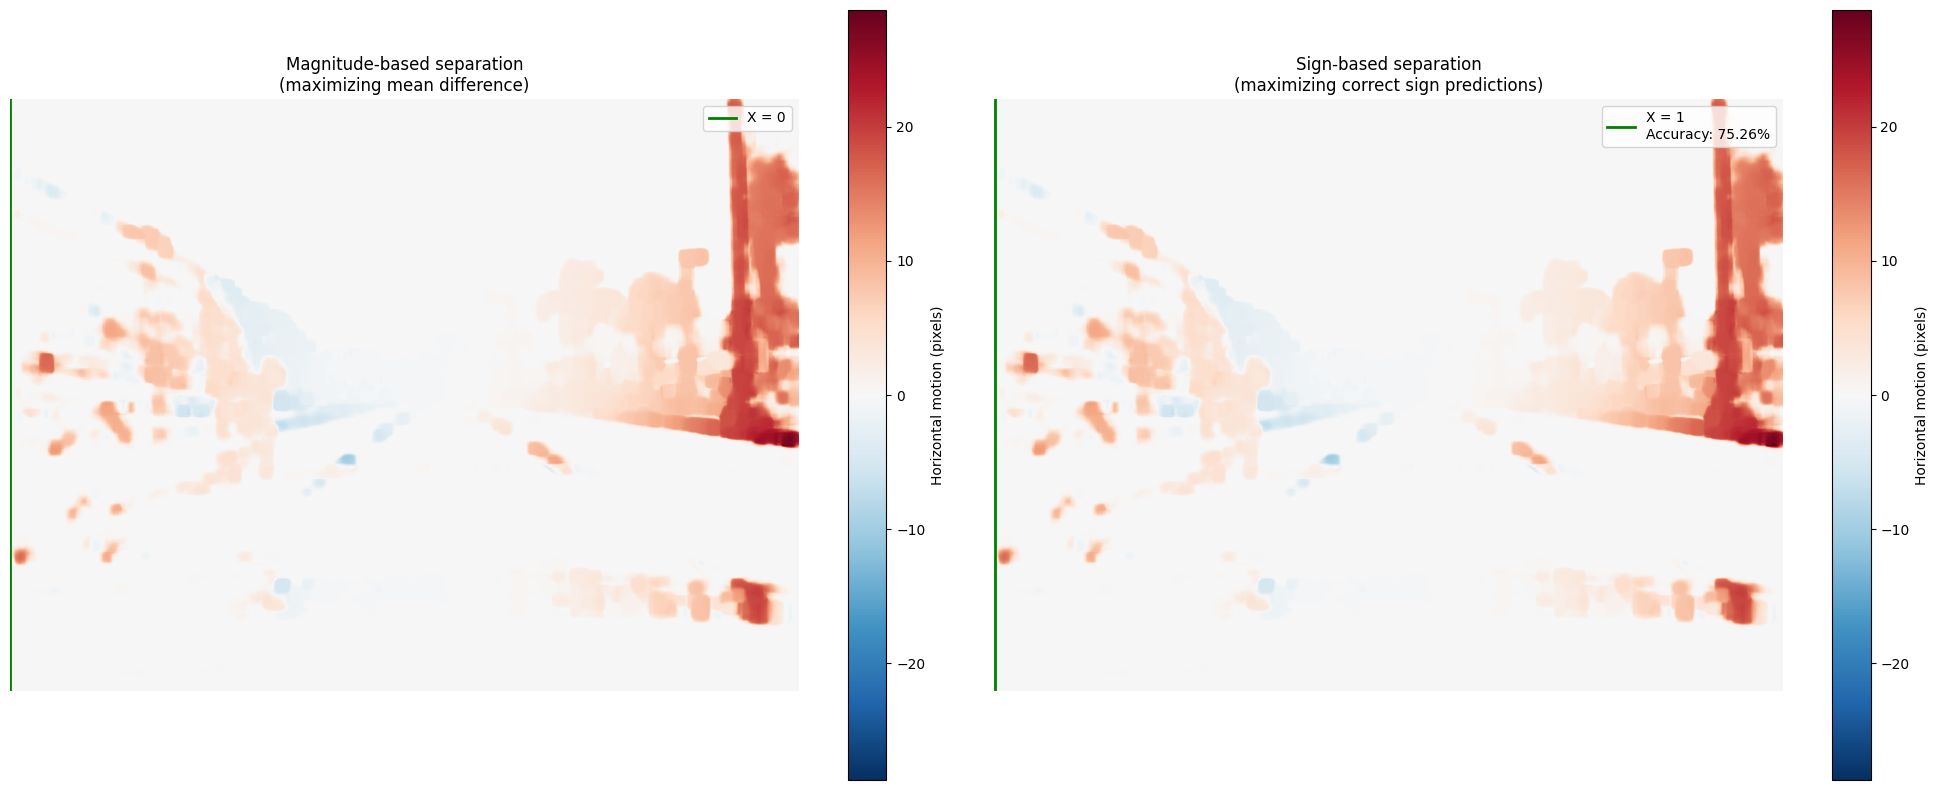

Magnitude-based method X: 0
Sign-based method X: 1 (Accuracy: 75.26%)


In [31]:
# Get the x-component of the flow (horizontal motion)
flow_x = flow[..., 0]
column_means = np.mean(flow_x, axis=0)
n = len(column_means)
total_sum = np.sum(column_means)

# Method 1: Using magnitude difference
cumsum1 = 0
best_x1 = 0
best_diff = float('-inf')

for i in range(n-1):
    cumsum1 += column_means[i]
    remaining_sum = total_sum - cumsum1
    
    left_mean = cumsum1 / (i + 1)
    right_mean = remaining_sum / (n - i - 1)
    
    if left_mean < 0 and right_mean > 0:
        diff = right_mean - left_mean
        if diff > best_diff:
            best_diff = diff
            best_x1 = i + 1

# Method 2: Using sign matching
cumsum2 = 0
best_x2 = 0
best_accuracy = 0

for i in range(n-1):
    cumsum2 += column_means[i]
    remaining_sum = total_sum - cumsum2
    
    left_matches = np.sum(column_means[:i+1] < 0)
    right_matches = np.sum(column_means[i+1:] > 0)
    accuracy = (left_matches + right_matches) / n
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_x2 = i + 1

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot for magnitude-based method
im1 = ax1.imshow(flow_x, cmap=plt.cm.RdBu_r, 
                 vmin=-np.max(np.abs(flow_x)), vmax=np.max(np.abs(flow_x)))
ax1.axvline(x=best_x1, color='g', linestyle='-', linewidth=2, 
            label=f'X = {best_x1}')
plt.colorbar(im1, ax=ax1, label='Horizontal motion (pixels)')
ax1.set_title('Magnitude-based separation\n(maximizing mean difference)')
ax1.legend()
ax1.axis('off')

# Plot for sign-based method
im2 = ax2.imshow(flow_x, cmap=plt.cm.RdBu_r, 
                 vmin=-np.max(np.abs(flow_x)), vmax=np.max(np.abs(flow_x)))
ax2.axvline(x=best_x2, color='g', linestyle='-', linewidth=2, 
            label=f'X = {best_x2}\nAccuracy: {best_accuracy:.2%}')
plt.colorbar(im2, ax=ax2, label='Horizontal motion (pixels)')
ax2.set_title('Sign-based separation\n(maximizing correct sign predictions)')
ax2.legend()
ax2.axis('off')

plt.tight_layout()
plt.show()

# Print numerical results
print(f"Magnitude-based method X: {best_x1}")
print(f"Sign-based method X: {best_x2} (Accuracy: {best_accuracy:.2%})")

Optimal X value: 1
Accuracy: 75.26%


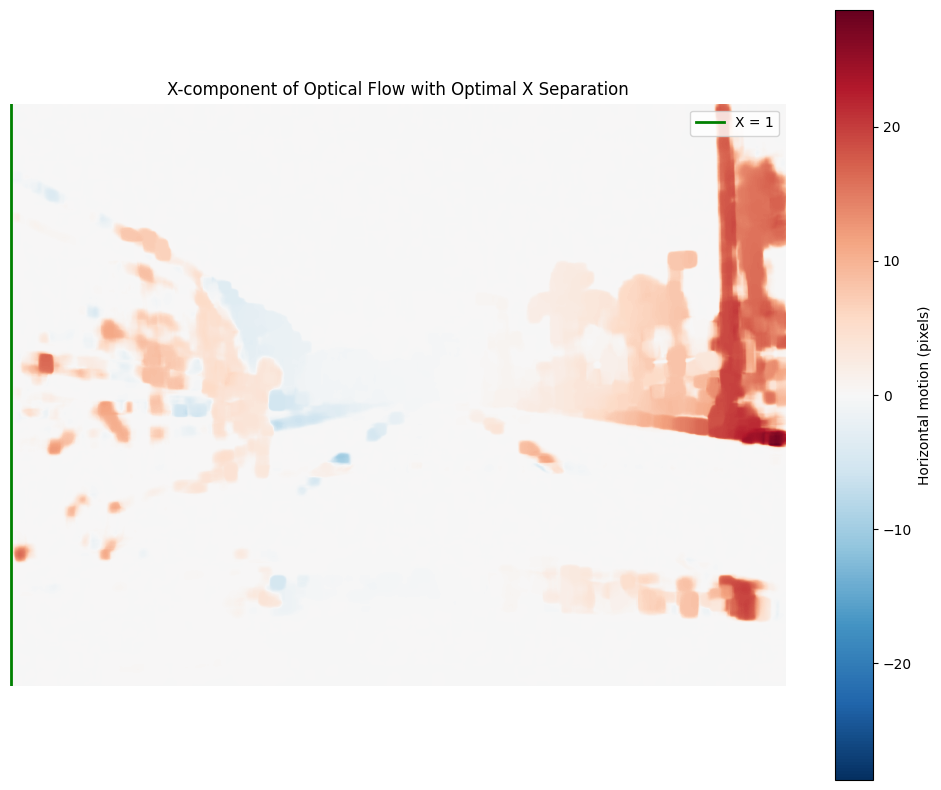

In [34]:
# Get the x-component of the flow (horizontal motion)
flow_x = flow[..., 0]

# Calculate mean for each column
column_means = np.mean(flow_x, axis=0)

# Find optimal split point
n = len(column_means)
total_sum = np.sum(column_means)
cumsum = 0
best_x = 0
best_accuracy = 0

for i in range(n-1):
    cumsum += column_means[i]
    remaining_sum = total_sum - cumsum
    
    left_mean = cumsum / (i + 1)
    right_mean = remaining_sum / (n - i - 1)
    
    # Count how many points follow the expected pattern
    # (negative on left, positive on right)
    left_matches = np.sum(column_means[:i+1] < 0)
    right_matches = np.sum(column_means[i+1:] > 0)
    accuracy = (left_matches + right_matches) / n
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_x = i + 1

print(f"Optimal X value: {best_x}")
print(f"Accuracy: {best_accuracy:.2%}")

# Visualize the result
plt.figure(figsize=(10, 8))

# Plot the x-component of flow
plt.imshow(flow_x, cmap=plt.cm.RdBu_r, 
           vmin=-np.max(np.abs(flow_x)), vmax=np.max(np.abs(flow_x)))

# Plot the vertical separation line
plt.axvline(x=best_x, color='g', linestyle='-', linewidth=2, label=f'X = {best_x}')

plt.colorbar(label='Horizontal motion (pixels)')
plt.title('X-component of Optical Flow with Optimal X Separation')
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()



Optimal Y value: 873
Accuracy: 67.16%


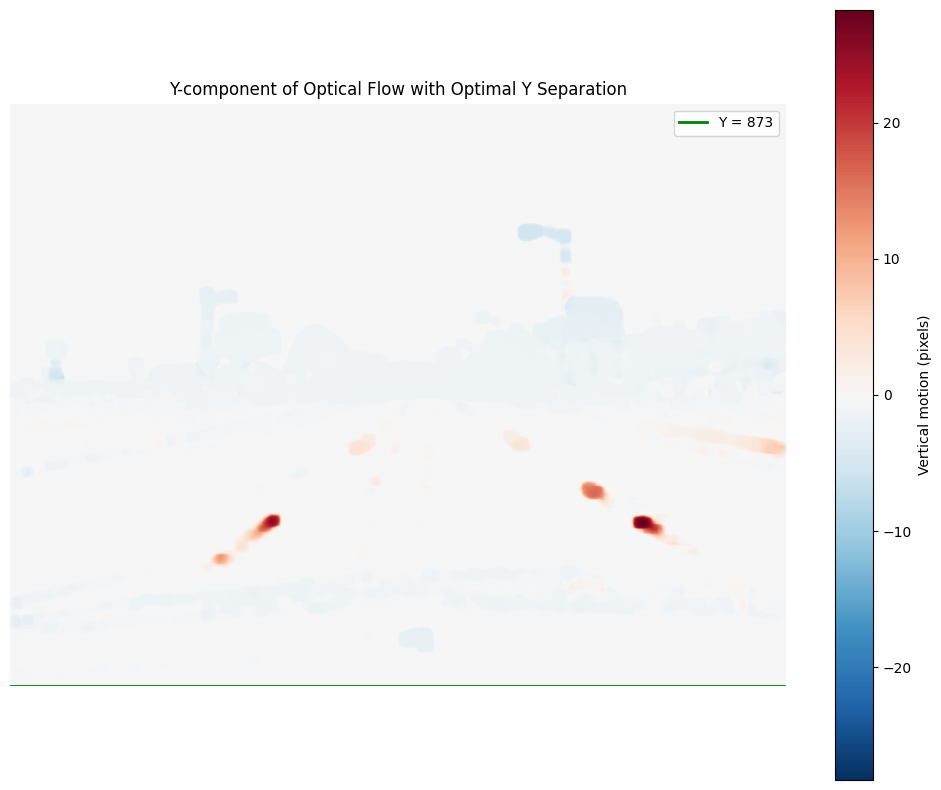

In [29]:
# Analyze the y-component of optical flow
flow_y = flow[..., 1]

# Calculate row means (average y-component for each row)
row_means = np.mean(flow_y, axis=1)

# Find optimal split point
n = len(row_means)
total_sum = np.sum(row_means)
cumsum = 0
best_y = 0
best_accuracy = 0

for i in range(n-1):
    cumsum += row_means[i]
    remaining_sum = total_sum - cumsum
    
    top_mean = cumsum / (i + 1)
    bottom_mean = remaining_sum / (n - i - 1)
    
    # Count how many points follow the expected pattern
    # (negative on top, positive on bottom)
    top_matches = np.sum(row_means[:i+1] < 0)
    bottom_matches = np.sum(row_means[i+1:] > 0)
    accuracy = (top_matches + bottom_matches) / n
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_y = i + 1

print(f"Optimal Y value: {best_y}")
print(f"Accuracy: {best_accuracy:.2%}")

# Visualize the result
plt.figure(figsize=(10, 8))

# Plot the y-component of flow
plt.imshow(flow_y, cmap=plt.cm.RdBu_r, 
           vmin=-np.max(np.abs(flow_y)), vmax=np.max(np.abs(flow_y)))

# Plot the horizontal separation line
plt.axhline(y=best_y, color='g', linestyle='-', linewidth=2, label=f'Y = {best_y}')

plt.colorbar(label='Vertical motion (pixels)')
plt.title('Y-component of Optical Flow with Optimal Y Separation')
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
# Load frames 184 and 185 from the video
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the yolo/src directory to the Python path
sys.path.append('../yolo/src')

# Import the necessary functions
from flow import calculate_flow, find_separation_points
from visualization import visualize_separation_points, create_flow_visualization
from detection import VehicleDetector

# Use the correct path to the video
video_path = '../calib_challenge/labeled/4.hevc'

# Open the video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video at {video_path}")
else:
    # Get total frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    
    # Set frame numbers
    frame1_num = 104
    frame2_num = frame1_num + 1
    print(f"prev frame number: {frame1_num}")
    dil_size = 10
    
    # Get frame 1 - Make sure to reset position and read frames sequentially
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i in range(frame1_num + 1):  # +1 because we're 0-indexed
        ret1, frame1 = cap.read()
        if not ret1:
            print(f"Error: Could not read frame {i}")
            break
    
    # Get frame 2 - Continue reading from current position
    ret2, frame2 = cap.read()
    
    if ret1 and ret2:
        # Verify we're at the right frames
        print(f"Current frame position: {int(cap.get(cv2.CAP_PROP_POS_FRAMES))}")
        
        # Initialize vehicle detector
        detector = VehicleDetector()
        
        # Detect vehicles and create masks
        vehicle_mask1 = detector.detect_vehicles(frame1)
        vehicle_mask2 = detector.detect_vehicles(frame2)
        vehicle_mask1 = detector.dilate_mask(vehicle_mask1, dil_size)
        vehicle_mask2 = detector.dilate_mask(vehicle_mask2, dil_size)
        
        # Charger le masque manuel sauvegardé
        mask_path = '../yolo/masks/4_mask.png'
        if os.path.exists(mask_path):
            manual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # S'assurer que le masque a la même taille que les frames
            if manual_mask.shape != vehicle_mask1.shape:
                manual_mask = cv2.resize(manual_mask, (vehicle_mask1.shape[1], vehicle_mask1.shape[0]))
        else:
            print(f"Attention: masque manuel non trouvé à {mask_path}, un masque vide sera utilisé.")
            manual_mask = np.zeros_like(vehicle_mask1)

        # Combine masks
        combined_mask = detector.combine_masks(manual_mask, vehicle_mask2, vehicle_mask1)

        
        # Convert to grayscale
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow
        flow, prev_gray_masked, gray_masked = calculate_flow(gray1, gray2, combined_mask)
        
        # Create visualizations
        plt.figure(figsize=(15, 6))
        
        # Visualization 2: Separation points
        plt.subplot(1, 2, 1)
        best_x, best_y = find_separation_points(flow, combined_mask)
        sep_vis = visualize_separation_points(frame2, best_x, best_y)
        plt.imshow(cv2.cvtColor(sep_vis, cv2.COLOR_BGR2RGB))
        plt.title('Points de séparation')
        plt.axis('off')
        
        # Visualization 3: Debug visualization
        plt.subplot(1, 2, 2)
        debug_vis = create_flow_visualization(flow, combined_mask, frame2)
        plt.imshow(cv2.cvtColor(debug_vis, cv2.COLOR_BGR2RGB))
        plt.title('Debug visualisation')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print separation points information
        print(f"\nPoints de séparation:")
        print(f"X: {best_x}, Y: {best_y}")
        # print(f"Accuracy X: {x_accuracy:.2f}, Accuracy Y: {y_accuracy:.2f}")
    else:
        print("Error: Could not read frames")
    
    # Release the video capture object
    cap.release()

Error: Could not open video at ../calib_challenge/labeled/4.hevc


OpenCV: Couldn't read video stream from file "../calib_challenge/labeled/4.hevc"


In [13]:
mask = combined_mask
flow_x = flow[..., 0]
flow_y = flow[..., 1]

# Créer un masque pour les pixels non masqués
valid_pixels = (mask == 0)

# Trouver la séparation X (en utilisant les moyennes des colonnes)
column_means = np.zeros(flow_x.shape[1])
for i in range(flow_x.shape[1]):
    # Calculer la moyenne uniquement sur les pixels non masqués
    valid_pixels_in_column = valid_pixels[:, i]
    if np.any(valid_pixels_in_column):
        column_means[i] = np.mean(flow_x[valid_pixels_in_column, i])

# On considère une tolérance pour "zéro" (par exemple, abs(mean) < 1e-2)
valid_cols = np.abs(column_means) > 1e-2
valid_indices = np.where(valid_cols)[0]

best_x = None
best_x_accuracy = 0

for idx, i in enumerate(valid_indices[:-1]):
    left = column_means[valid_indices[:idx+1]]
    right = column_means[valid_indices[idx+1:]]
    left_matches = np.sum(left < 0)
    right_matches = np.sum(right > 0)
    n = len(left) + len(right)
    accuracy = (left_matches + right_matches) / n if n > 0 else 0
    if accuracy > best_x_accuracy:
        best_x_accuracy = accuracy
        best_x = i

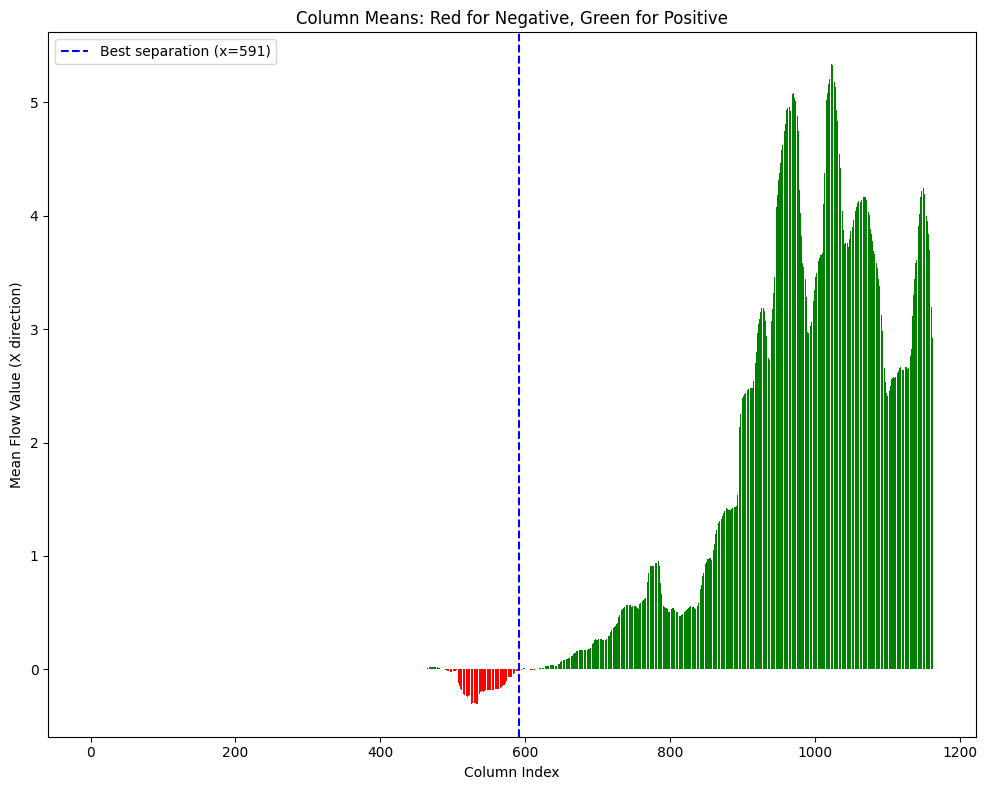

array([-2.8452e-05, -3.0599e-05, -1.8568e-06, ...,      3.1952,      2.9201,      2.5419])

In [11]:
# Visualize column_means with red for negative values and green for positive values
plt.figure(figsize=(10, 8))
plt.bar(range(len(column_means)), column_means, 
        color=['red' if x < 0 else 'green' for x in column_means])
plt.axvline(x=best_x, color='blue', linestyle='--', label=f'Best separation (x={best_x})')
plt.title('Column Means: Red for Negative, Green for Positive')
plt.xlabel('Column Index')
plt.ylabel('Mean Flow Value (X direction)')
plt.legend()
plt.tight_layout()
plt.show()

# Return the array for inspection
column_means

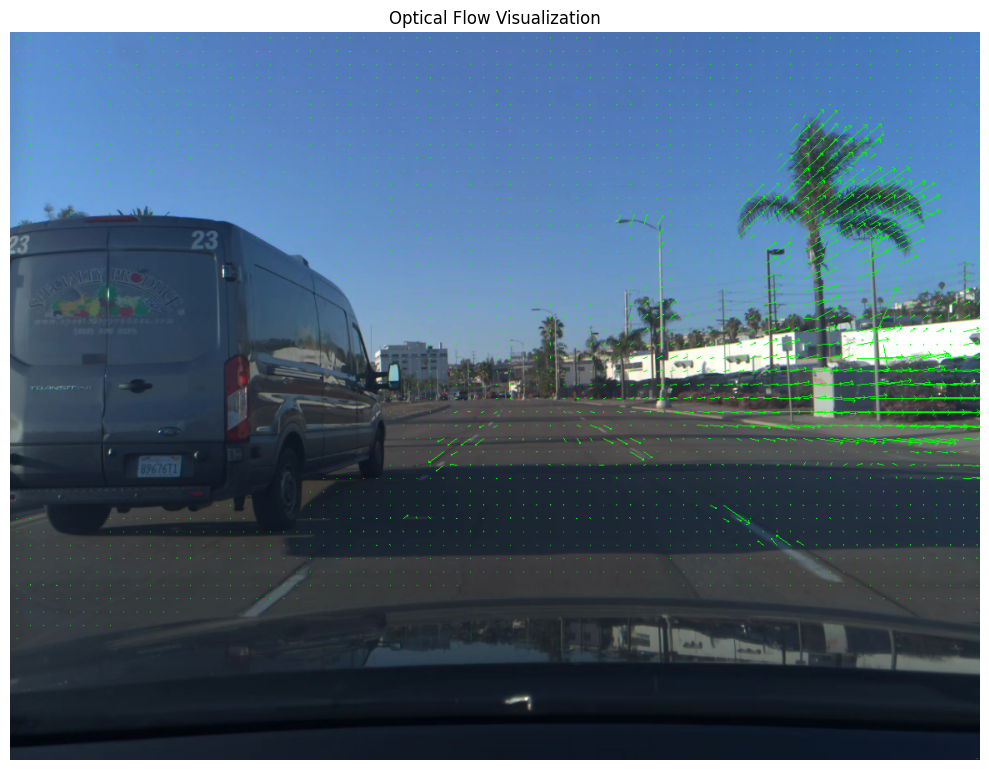

Maximum flow magnitude: 45


In [5]:
# Visualize the optical flow with arrows
def visualize_flow_arrows(frame, flow, mask, step=16, scale=3, color=(0, 255, 0), thickness=1):
    """
    Visualize optical flow with arrows on the frame
    """
    img = frame.copy()
    h, w = flow.shape[:2]
    
    # Create a grid of points to draw arrows
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    
    # Create mask of valid flow points
    valid_points = mask[y, x] == 0
    
    # Filter points based on mask
    lines = np.vstack([x[valid_points], y[valid_points], 
                       (x + fx*scale)[valid_points], 
                       (y + fy*scale)[valid_points]]).T.reshape(-1, 2, 2)
    lines = np.int32(lines)
    
    # Draw the arrows
    for (x1, y1), (x2, y2) in lines:
        cv2.arrowedLine(img, (x1, y1), (x2, y2), color, thickness=thickness)
    
    return img

# Visualize the optical flow
plt.figure(figsize=(10, 8))
flow_vis = visualize_flow_arrows(frame2, flow, combined_mask)
plt.imshow(cv2.cvtColor(flow_vis, cv2.COLOR_BGR2RGB))
plt.title('Optical Flow Visualization')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print the maximum flow value for reference
max_flow = np.max(np.sqrt(flow[..., 0]**2 + flow[..., 1]**2))
print(f"Maximum flow magnitude: {int(max_flow)}")



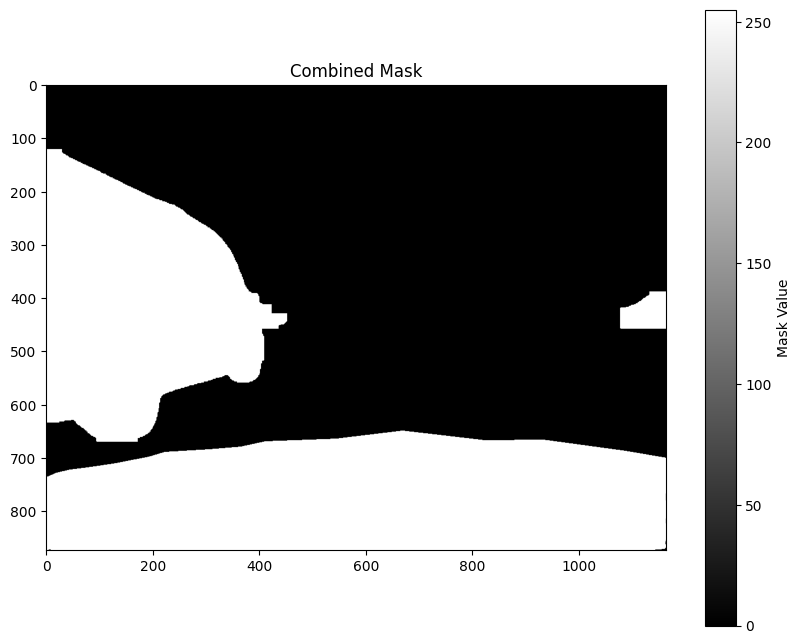

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [13]:
# Visualize the combined mask
plt.figure(figsize=(10, 8))
plt.imshow(combined_mask, cmap='gray')
plt.title('Combined Mask')
plt.colorbar(label='Mask Value')
plt.axis('on')
plt.show()

# Display the mask array
combined_mask
